# TP2 : Classification de texte avec sklearn

# Part 1:

1. Imports and setup

In [7]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score

2. Load and preprocess dataset

In [8]:
# Load the provided spam.csv
df = pd.read_csv("spam.csv", encoding="latin-1")

# Drop any rows with missing values
df = df.dropna(subset=["text", "label"])

# Make sure text is treated as string
df["text"] = df["text"].astype(str)

# Strip unwanted characters and lowercase text
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df["text_clean"] = df["text"].apply(preprocess)

# Remove any rows where text is now empty
df = df[df["text_clean"].str.strip() != ""]


3. Fonction de vectorisation et evaluation

In [9]:
def vectorize_and_evaluate(vectorizer, name):
    X = vectorizer.fit_transform(df["text_clean"])
    y = df["label"].astype(int)
    
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=100),
        "MLP": MLPClassifier(max_iter=300)
    }

    results = {}
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model_name, model in models.items():
        acc = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(accuracy_score)).mean()
        f1 = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score)).mean()
        results[model_name] = {"accuracy": acc, "f1_score": f1}
        print(f"{name} - {model_name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")
    
    return results


4. Executer BoW et TF-IDF

In [10]:
print("Bag of Words (BoW) Results")
bow_vectorizer = CountVectorizer(max_features=5000)
bow_results = vectorize_and_evaluate(bow_vectorizer, "BoW")

print("\nTF-IDF Results")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_results = vectorize_and_evaluate(tfidf_vectorizer, "TF-IDF")


Bag of Words (BoW) Results
BoW - LogisticRegression: Accuracy = 0.9791, F1 Score = 0.9172
BoW - RandomForest: Accuracy = 0.9731, F1 Score = 0.8889
BoW - MLP: Accuracy = 0.9814, F1 Score = 0.9259

TF-IDF Results
TF-IDF - LogisticRegression: Accuracy = 0.9585, F1 Score = 0.8180
TF-IDF - RandomForest: Accuracy = 0.9724, F1 Score = 0.8867
TF-IDF - MLP: Accuracy = 0.9829, F1 Score = 0.9303


5. Performance vs max_features

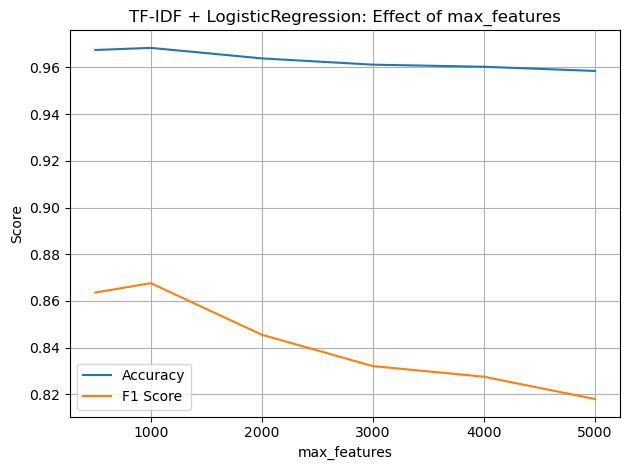

In [11]:
def plot_feature_effects():
    feature_range = [500, 1000, 2000, 3000, 4000, 5000]
    accs, f1s = [], []

    for n in feature_range:
        vec = TfidfVectorizer(max_features=n)
        X = vec.fit_transform(df["text_clean"])
        y = df["label"].astype(int)

        model = LogisticRegression(max_iter=1000)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        acc = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(accuracy_score)).mean()
        f1 = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(f1_score)).mean()

        accs.append(acc)
        f1s.append(f1)

    plt.plot(feature_range, accs, label="Accuracy")
    plt.plot(feature_range, f1s, label="F1 Score")
    plt.xlabel("max_features")
    plt.ylabel("Score")
    plt.title("TF-IDF + LogisticRegression: Effect of max_features")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_effects()


# Part2:

1. Re-imports and load data

In [12]:
import pandas as pd
import numpy as np
import re

# Charger les données
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df.dropna(subset=["text", "label"])
df["text"] = df["text"].astype(str)

# Nettoyage de texte
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df["text_clean"] = df["text"].apply(preprocess)
df = df[df["text_clean"].str.strip() != ""]

y = df["label"].astype(int)


2. Generation des embeddings

In [15]:


from sentence_transformers import SentenceTransformer

# Utiliser un modèle léger et compatible CPU
model = SentenceTransformer("all-MiniLM-L6-v2")

# Convertir chaque texte en vecteur
X_embeddings = model.encode(df["text_clean"].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/140 [00:00<?, ?it/s]

3. Entrainement et evaluation des modeles

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100),
    "MLP": MLPClassifier(max_iter=300)
}

results_embeddings = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc = cross_val_score(model, X_embeddings, y, cv=skf, scoring=make_scorer(accuracy_score)).mean()
    f1 = cross_val_score(model, X_embeddings, y, cv=skf, scoring=make_scorer(f1_score)).mean()
    results_embeddings[name] = {"accuracy": acc, "f1_score": f1}
    print(f"Embeddings - {name}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")


Embeddings - LogisticRegression: Accuracy = 0.9690, F1 Score = 0.8753
Embeddings - RandomForest: Accuracy = 0.9520, F1 Score = 0.7863
Embeddings - MLP: Accuracy = 0.9814, F1 Score = 0.9330


part3:

Définir les modèles de base:

In [2]:
# Utilisation des colonnes déjà correctes
df_raw = pd.read_csv("spam.csv", encoding='latin-1')

# Nettoyage du texte
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

df_raw["text_clean"] = df_raw["text"].apply(preprocess)
df = df_raw[df_raw["text_clean"].str.strip() != ""]

# Vectorisation TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['text_clean']).toarray()
y = df['label'].values

# Définition des modèles de base
base_models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100, n_jobs=-1),
    make_pipeline(StandardScaler(), SVC(probability=True, kernel='linear'))
]

# Métamodèle
meta_model = LogisticRegression()

# Validation croisée
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
meta_features = np.zeros((X.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    for train_idx, val_idx in kf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict_proba(X[val_idx])[:, 1]
        meta_features[val_idx, i] = preds

# Entraînement du métamodèle
meta_model.fit(meta_features, y)

# Évaluation
meta_preds = meta_model.predict(meta_features)
acc = accuracy_score(y, meta_preds)
f1 = f1_score(y, meta_preds)
meta_weights = meta_model.coef_

acc, f1, meta_weights


NameError: name 'pd' is not defined

Créer les prédictions des base learners (avec K-fold CV)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

meta_model = LogisticRegression()
meta_model.fit(Z, y)

# On prédit sur les mêmes données (ou séparer un X_test pour plus rigueur)
Z_test = np.column_stack([
    model.fit(X, y).predict_proba(X)[:, 1]
    for _, model in base_models
])
final_preds = meta_model.predict(Z_test)

# Résultats
print("Accuracy:", accuracy_score(y, final_preds))
print("F1 Score:", f1_score(y, final_preds))
print("Poids appris par le méta-modèle :", meta_model.coef_)


Entraîner le méta-modèle

In [ ]:
meta_model = LogisticRegression()
meta_model.fit(Z, y_array)


Évaluer le Super Learner:

In [ ]:
Z_test = np.column_stack([
    model.fit(X, y_array).predict_proba(X)[:, 1]
    for name, model in base_models
])
final_preds = meta_model.predict(Z_test)


Calculer l’accuracy et le F1-score

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print("Accuracy:", accuracy_score(y_array, final_preds))
print("F1 Score:", f1_score(y_array, final_preds))
